<a href="https://colab.research.google.com/github/tuliopradoc/analise-dados-enem-2020/blob/main/Enem_2020_Redacao_Prediction/Enem_2020_Redacao_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predição das notas de redação no ENEM com base no questionário socioeconômico**

Dados: https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/enem

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MaxAbsScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
# Conjunto usado para teste foi obtido a partir dos microdados do enem 2020
# Os ouliers e os NaN já foram removidos

X_test = pd.read_csv('/content/drive/MyDrive/Datasets/ENEM -2020/Enem_2020_test.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Datasets/ENEM -2020/Enem_2020_y_test.csv')

In [5]:
# Conjunto usado para treino foi obtido a partir dos microdados do enem 2019

X_train = pd.read_csv('/content/drive/MyDrive/Datasets/ENEM-2019/Enem_Q_REDACAO_train.csv')
questionario = pd.read_csv('/content/drive/MyDrive/Datasets/ENEM -2020/questionario.csv')

In [6]:
X_train.head()

,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,...,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NU_NOTA_REDACAO
0,C,E,B,D,4,E,A,C,C,A,...,A,A,C,A,B,D,A,B,B,460.0
1,E,E,C,C,3,G,A,C,D,B,...,A,A,B,A,A,C,B,B,B,860.0
2,B,B,C,B,7,E,A,B,D,A,...,A,A,B,A,A,E,A,B,B,800.0
3,E,B,C,B,3,B,A,B,B,A,...,A,A,B,A,A,B,A,A,A,600.0
4,E,E,B,B,5,F,A,B,C,B,...,A,A,B,A,B,C,B,B,B,400.0


In [7]:
questionario

,Questões,Descrição
0,Q001,"Até que série seu pai, ou o homem responsável ..."
1,Q002,"Até que série sua mãe, ou a mulher responsável..."
2,Q003,A partir da apresentação de algumas ocupações ...
3,Q004,A partir da apresentação de algumas ocupações ...
4,Q005,"Incluindo você, quantas pessoas moram atualmen..."
5,Q006,Qual é a renda mensal de sua família? (Some a ...
6,Q007,Em sua residência trabalha empregado(a) domést...
7,Q008,Na sua residência tem banheiro?
8,Q009,Na sua residência tem quartos para dormir?
9,Q010,Na sua residência tem carro?


### **Pré-processamento:**

In [8]:
X_train.isna().sum()

Q001               0
Q002               0
Q003               0
Q004               0
Q005               0
Q006               0
Q007               0
Q008               0
Q009               0
Q010               0
Q011               0
Q012               0
Q013               0
Q014               0
Q015               0
Q016               0
Q017               0
Q018               0
Q019               0
Q020               0
Q021               0
Q022               0
Q023               0
Q024               0
Q025               0
NU_NOTA_REDACAO    0
dtype: int64

 **Remoção de outliers:**

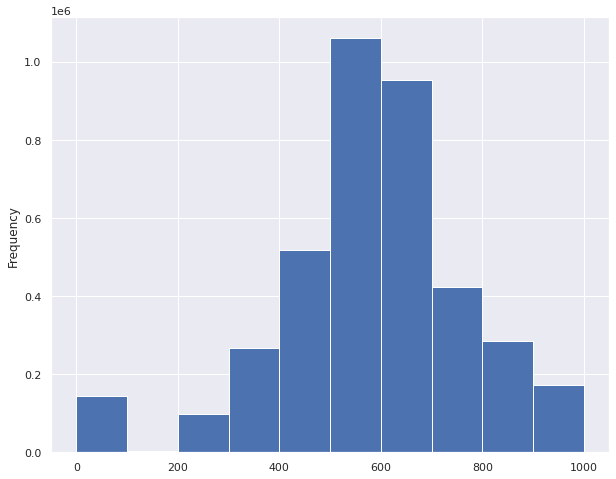

In [9]:
sns.set()
fig, ax = plt.subplots(figsize = (10,8))
X_train['NU_NOTA_REDACAO'].plot(kind='hist', ax = ax)

In [10]:
X_train_without_outliers = X_train[X_train.NU_NOTA_REDACAO >= 200]

In [11]:
X = X_train_without_outliers.drop(['NU_NOTA_REDACAO'], axis = 1)

y = X_train_without_outliers['NU_NOTA_REDACAO']

 **Separando variáveis categóricas:**

In [12]:
X.columns.values

array(['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008',
       'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016',
       'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024',
       'Q025'], dtype=object)

In [13]:
nominal_features = ['Q001', 'Q002', 'Q003', 'Q004', 'Q006', 'Q007', 'Q008',
       'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016',
       'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024',
       'Q025']

In [14]:
nominal_transformer = Pipeline(steps= [('onehotenc', OneHotEncoder(handle_unknown = 'ignore'))])


preprocessor = ColumnTransformer(transformers = [('cat_nom', nominal_transformer, nominal_features)])

### **Pipeline:**

In [15]:
pipe = Pipeline(steps = [('preprocessing', preprocessor),
                         ('normalize', MaxAbsScaler()),   # normalização
                         ('standardization', StandardScaler(with_mean=False)),    # padronização
                         ('regressor', HuberRegressor())])

### **Validação cruzada:**

In [16]:
results = cross_validate(pipe, X, y, cv = 5, scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error'])

In [17]:
df_results = pd.DataFrame(results).abs()

In [18]:
df_results


,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error
0,77.627953,5.066104,113.803468,21529.342623
1,74.298507,5.036151,111.444040,20590.421422
2,51.972350,5.044244,110.236134,20123.966975
3,52.267306,4.996723,109.246084,19698.322544
4,61.496015,5.152996,107.521599,19257.548981


### **Treinando:**

In [19]:
pipe.fit(X,y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat_nom',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Q001', 'Q002', 'Q003',
                                                   'Q004', 'Q006', 'Q007',
                                                   'Q008', 'Q009', 'Q010',
                                                   'Q011', 'Q012', 'Q013',
                                                   'Q014', 'Q015', 'Q016',
                                                   'Q017', 'Q018', 'Q019',
                                                   'Q020', 'Q021', 'Q022',
                                                   'Q023', 'Q024', 'Q025'])])),
                ('normalize', MaxAbsScaler()),
                ('standardization', StandardScaler(with_mean=Fa

### **Predição:**

In [20]:
X_test

,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,C,B,C,B,5.0,C,A,B,E,A,...,B,A,A,B,B,A,D,A,B,B
1,B,C,C,B,2.0,B,A,B,C,A,...,A,A,A,B,A,A,C,A,A,A
2,B,C,C,B,5.0,B,A,B,C,A,...,A,B,A,B,A,A,C,A,B,B
3,C,C,C,B,2.0,B,A,B,C,A,...,A,A,A,B,B,A,C,A,B,B
4,C,D,C,C,5.0,D,A,C,C,A,...,A,A,A,B,B,A,C,A,A,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2643727,B,D,A,F,4.0,B,A,B,B,A,...,A,A,A,B,A,A,D,A,B,B
2643728,A,B,A,A,7.0,C,A,B,D,A,...,B,A,A,B,A,A,D,A,A,A
2643729,D,D,C,B,4.0,C,A,B,C,A,...,B,A,A,B,A,A,D,A,A,A
2643730,E,G,A,D,5.0,G,A,C,C,B,...,B,A,A,B,A,A,D,A,B,B


In [21]:
X_test.isna().sum()

Q001    0
Q002    0
Q003    0
Q004    0
Q005    0
Q006    0
Q007    0
Q008    0
Q009    0
Q010    0
Q011    0
Q012    0
Q013    0
Q014    0
Q015    0
Q016    0
Q017    0
Q018    0
Q019    0
Q020    0
Q021    0
Q022    0
Q023    0
Q024    0
Q025    0
dtype: int64

In [22]:
y_predict = pipe.predict(X_test)

In [23]:
mean_absolute_error(y_test, y_predict)

129.3125147224697

In [24]:
mean_squared_error(y_test, y_predict)

26230.392236886575